In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed
mean_gray = 0.1307
stddev_gray = 0.3081


In [ ]:
#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn)
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))])


100%|██████████| 9912422/9912422 [00:00<00:00, 136190119.94it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112684366.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38288672.09it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21381064.84it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



4


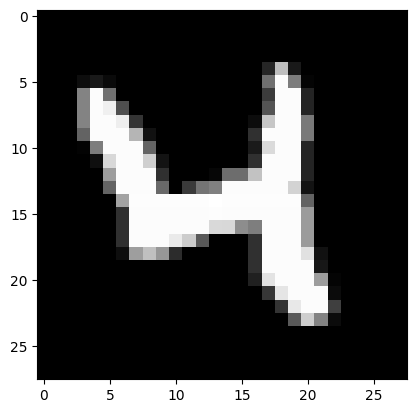

In [ ]:
#Load our dataset
train_dataset = datasets.MNIST(root = './data',
                            train = True,
                            transform = transforms,
                            download = True)

test_dataset = datasets.MNIST(root = './data',
                            train = False,
                            transform = transforms)
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')
print(train_dataset[20][1])   #Print the corresponding label for the image
#Make the dataset iterable
batch_size = 100


In [ ]:

train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))



There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()
    self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride=1, padding = 1)
    self.batchnorm1 = nn.BatchNorm2d(8)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size = 2)
    self.cnn2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(1568,600)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(600,10)

  def forward(self, x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = out.view(-1,1568)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    return out

In [ ]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
#Understand what's happening
iteration = 0
correct = 0
for i,(inputs,labels) in enumerate (train_load):

    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()

    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted Shape",predicted.shape)
    print("Predicted Tensor:")
    print(predicted)
    correct += (predicted == labels).sum()
    break


For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([6, 6, 6, 0, 6, 6, 6, 0, 2, 6, 2, 7, 3, 6, 3, 2, 0, 6, 6, 3, 1, 6, 0, 6,
        6, 6, 6, 6, 2, 2, 9, 2, 6, 6, 2, 9, 6, 0, 2, 6, 6, 2, 6, 6, 6, 6, 0, 6,
        3, 1, 6, 6, 0, 6, 6, 6, 8, 3, 6, 9, 6, 6, 6, 6, 1, 6, 2, 6, 1, 9, 2, 3,
        6, 2, 6, 9, 6, 6, 6, 9, 9, 2, 9, 6, 5, 6, 6, 9, 6, 9, 6, 6, 6, 6, 2, 6,
        9, 6, 3, 2], device='cuda:0')


In [ ]:
#Training the CNN
num_epochs = 25

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()

    for i, (inputs, labels) in enumerate(train_load):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()         # Accumulate the loss
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update the weights


        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)

    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))


    #Testing
    testing_loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode

    for i, (inputs, labels) in enumerate(test_load):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)

    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))

    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1],
             test_loss[-1], test_accuracy[-1]))

Epoch 1/25, Training Loss: 0.025, Training Accuracy: 99.247, Testing Loss: 0.028, Testing Acc: 99.030
Epoch 2/25, Training Loss: 0.025, Training Accuracy: 99.292, Testing Loss: 0.028, Testing Acc: 99.000
Epoch 3/25, Training Loss: 0.023, Training Accuracy: 99.370, Testing Loss: 0.028, Testing Acc: 98.980
Epoch 4/25, Training Loss: 0.023, Training Accuracy: 99.348, Testing Loss: 0.028, Testing Acc: 98.950
Epoch 5/25, Training Loss: 0.022, Training Accuracy: 99.365, Testing Loss: 0.028, Testing Acc: 98.990
Epoch 6/25, Training Loss: 0.022, Training Accuracy: 99.388, Testing Loss: 0.027, Testing Acc: 99.020
Epoch 7/25, Training Loss: 0.020, Training Accuracy: 99.412, Testing Loss: 0.028, Testing Acc: 99.030
Epoch 8/25, Training Loss: 0.020, Training Accuracy: 99.435, Testing Loss: 0.027, Testing Acc: 99.050
Epoch 9/25, Training Loss: 0.020, Training Accuracy: 99.452, Testing Loss: 0.028, Testing Acc: 99.020
Epoch 10/25, Training Loss: 0.020, Training Accuracy: 99.412, Testing Loss: 0.027,

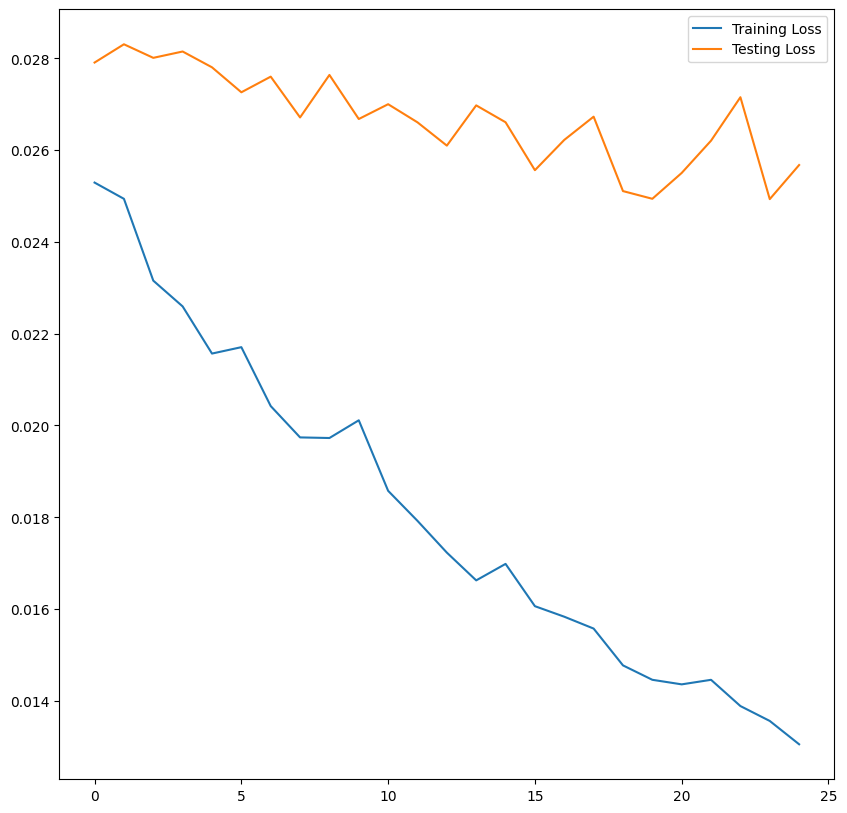

TypeError: ignored

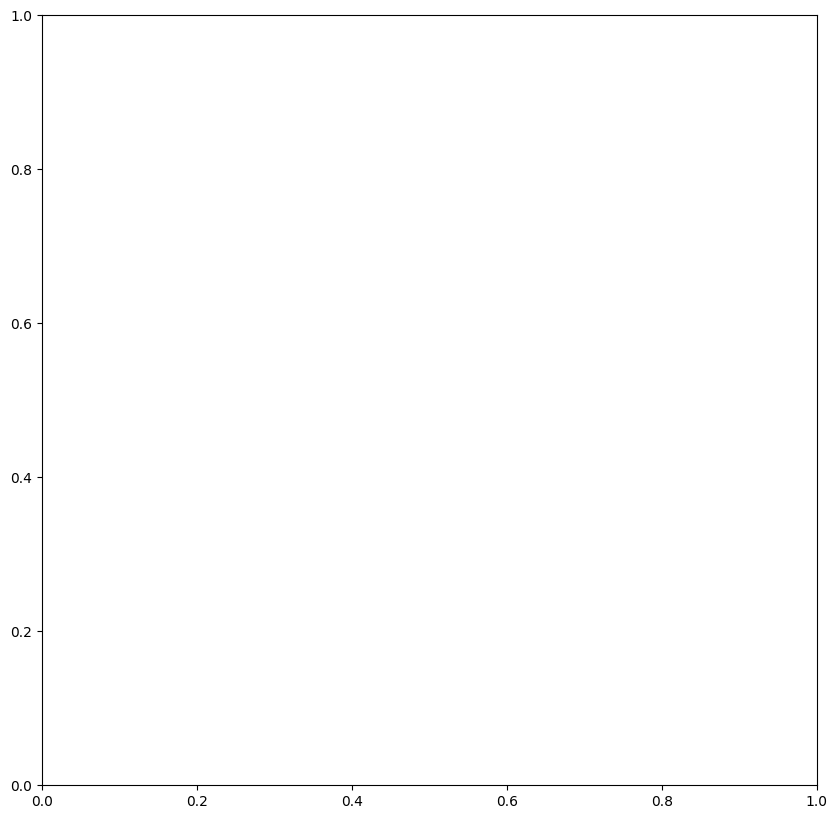

In [ ]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

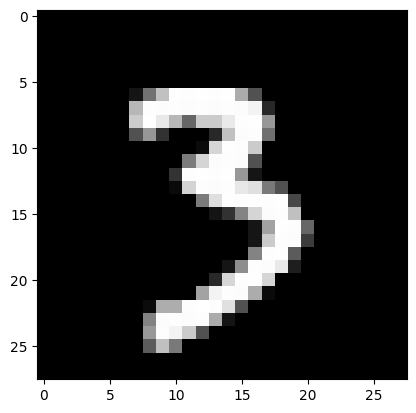

Prediction is: 3
Actual is: 3


In [ ]:
img = test_dataset[30][0].resize_((1, 1, 28, 28))
label = test_dataset[30][1]
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()

output = model(img)


_, predicted = torch.max(output,1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))